In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time
from typing import List, Optional, Tuple

import arviz as az
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import string_functions as stringr
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 332
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data preparation (coppied)

In [3]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)

data = data.sort_values(["hugo_symbol", "sgrna", "depmap_id"]).reset_index(drop=True)
for col in ("hugo_symbol", "depmap_id", "sgrna", "lineage", "chromosome"):
    data = dphelp.make_cat(data, col, ordered=True, sort_cats=False)

data["log2_cn"] = np.log2(data.gene_cn + 1)
data = dphelp.zscale_cna_by_group(
    data, gene_cn_col="log2_cn", new_col="z_log2_cn", cn_max=np.log2(10)
)
data["is_mutated"] = dphelp.nmutations_to_binary_array(data.n_muts)

---

### Model 7. Introduce a covariate for the KRAS allele to model 6

Finally, we can add a categorical variable for the *KRAS* allele of a tumor sample.

$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_s + \gamma_g M + \delta_g \log_2 C + \epsilon_g K\\
\quad \alpha_s \sim \mathcal{N}(\mu_{\alpha_s}, \sigma_{\alpha_s}) \\
\qquad \mu_{\alpha_s} = g_s \\ 
\qquad \quad g_s \sim \mathcal{N}(\mu_g, \sigma_g) \\ 
\qquad \qquad \mu_g \sim \mathcal{N}(0, 5) \quad \sigma_g \sim \text{Exp}(1) \\ 
\qquad \sigma_\alpha \sim \text{Exp}(1) \\ 
\quad \gamma_g \sim \mathcal{N}(\mu_{\gamma_g}, \sigma_{\gamma_g}) \\ 
\qquad \mu_{\gamma_g} \sim \mathcal{N}(0, 2) \\ 
\qquad \sigma_{\gamma_g} \sim \text{HalfNormal}(2) \\ 
\quad \delta_g \sim \mathcal{N}(\mu_{\delta_g}, \sigma_{\delta_g}) \\ 
\qquad \mu_{\delta_g} \sim \mathcal{N}(-0.2, 2) \\ 
\qquad \sigma_{\delta_g} \sim \text{HalfNormal}(2) \\ 
\quad \epsilon_g \sim \mathcal{N}(\mu_{\epsilon_g}, \sigma_{\epsilon_g}) \\ 
\qquad \mu_{\epsilon_g} \sim \mathcal{N}(0, 0.5) \\ 
\qquad \sigma_{\epsilon_g} \sim \text{Exponential}(1) \\ 
\sigma \sim \text{HalfNormal}(5)
$

In [11]:
# List of KRAS alleles to keep separate. The rest will be "other".
MIN_KRAS_ALLELE_COUNT = 5
kras_counts = pd.get_dummies(
    data[["depmap_id", "kras_mutation"]].drop_duplicates()[["kras_mutation"]]
)
alleles_to_keep = (
    kras_counts.sum().index.values[kras_counts.sum() >= MIN_KRAS_ALLELE_COUNT].tolist()
)
alleles_to_keep = [a.replace("kras_mutation_", "") for a in alleles_to_keep]

# Dummy matrix for the alleles.
data = data.assign(
    kras_mutation_idx=lambda d: [
        a if a in alleles_to_keep else "other" for a in d.kras_mutation
    ]
)
data = dphelp.make_cat(data, "kras_mutation_idx")
kras_dummy_matrix = np.array(pd.get_dummies(data[["kras_mutation_idx"]]))

In [12]:
gene_idx, num_genes = dphelp.get_indices_and_count(data, "hugo_symbol")
sgrna_idx, num_sgrnas = dphelp.get_indices_and_count(data, "sgrna")
kras_idx, num_kras = dphelp.get_indices_and_count(data, "kras_mutation_idx")

sgrna_to_gene_map = data[["sgrna", "hugo_symbol"]].drop_duplicates()
sgrna_gene_idx = dphelp.get_indices(sgrna_to_gene_map, "hugo_symbol")

In [17]:
with pm.Model() as m7:
    # Indices
    sgrna_gene_idx_shared = pm.Data("sgrna_gene_idx", sgrna_gene_idx)
    sgrna_idx_shared = pm.Data("sgrna_idx_shared", sgrna_idx)
    gene_idx_shared = pm.Data("gene_idx_shared", gene_idx)
    kras_idx_shared = pm.Data("kras_idx_shared", kras_idx)

    # Data
    is_mutated_shared = pm.Data(
        "is_mutated_shared", dphelp.extract_flat_ary(data.is_mutated)
    )
    scaled_log2_cn_shared = pm.Data(
        "scaled_log2_cn_shared", dphelp.extract_flat_ary(data.z_log2_cn)
    )
    lfc_shared = pm.Data("lfc_shared", dphelp.extract_flat_ary(data.lfc))

    μ_g = pm.Normal("μ_g", 0, 5)
    σ_g = pm.Exponential("σ_g", 1)

    g_s = pm.Normal("g_s", μ_g, σ_g, shape=num_genes)

    μ_α_s = pm.Deterministic("μ_α_s", g_s[sgrna_gene_idx_shared])
    σ_α_s = pm.Exponential("σ_α_s", 1)
    μ_γ_g = pm.Normal("μ_γ_g", 0, 2)
    σ_γ_g = pm.HalfNormal("σ_γ_g", 2)
    μ_δ_g = pm.Normal("μ_δ_g", -0.2, 2)
    σ_δ_g = pm.HalfNormal("σ_δ_g", 2)
    μ_ϵ_g = pm.Normal("μ_ϵ_g", 0, 0.2)
    σ_ϵ_g = pm.Exponential("σ_ϵ_g", 0.3)

    α_s = pm.Normal("α_s", μ_α_s, σ_α_s, shape=num_sgrnas)
    γ_g = pm.Normal("γ_g", μ_γ_g, σ_γ_g, shape=num_genes)
    δ_g = pm.Normal("δ_g", μ_δ_g, σ_δ_g, shape=num_genes)
    ϵ_gk = pm.Normal("ϵ_gk", μ_ϵ_g, σ_ϵ_g, shape=(num_genes, num_kras))

    μ = pm.Deterministic(
        "μ",
        α_s[sgrna_idx_shared]
        + γ_g[gene_idx_shared] * is_mutated_shared
        + δ_g[gene_idx_shared] * scaled_log2_cn_shared
        + ϵ_gk[gene_idx_shared, kras_idx_shared],
    )
    σ = pm.HalfNormal("σ", 5)

    y = pm.Normal("y", μ, σ, observed=lfc_shared)

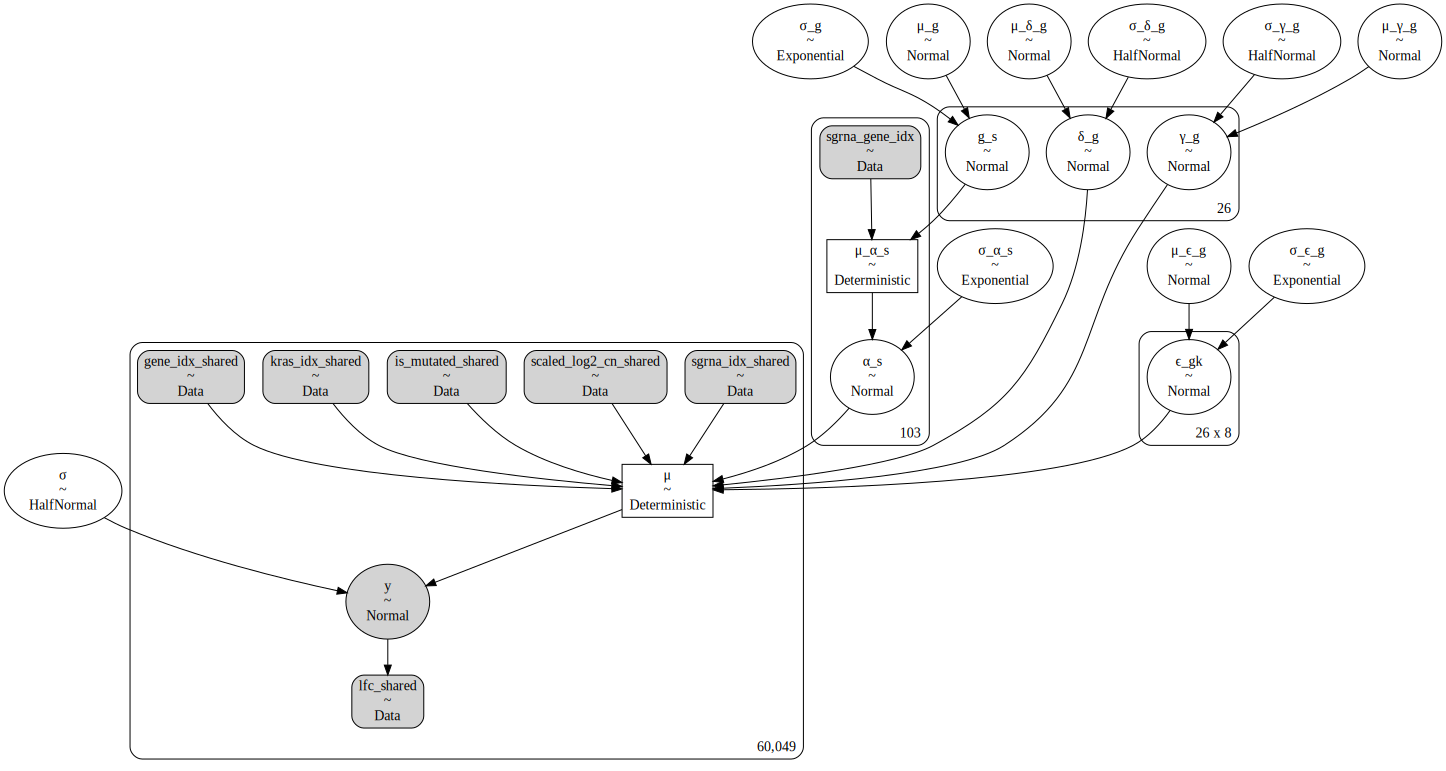

In [18]:
pm.model_to_graphviz(m7)

In [19]:
m7_cache_dir = pymc3_cache_dir / "subset_speclet_m7"

m7_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=m7,
    num_mcmc=2000,
    tune=4000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=pymc3_cache_dir / m7_cache_dir,
    force=False,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 40000},
)

m7_az = pmhelp.samples_to_arviz(model=m7, res=m7_sampling_results)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 30400
Interrupted at 30,399 [75%]: Average Loss = 55,294
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, ϵ_gk, δ_g, γ_g, α_s, σ_ϵ_g, μ_ϵ_g, σ_δ_g, μ_δ_g, σ_γ_g, μ_γ_g, σ_α_s, g_s, σ_g, μ_g]


ValueError: Not enough samples to build a trace.

---

In [6]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.13 minutes


In [7]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-25

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-231.o2.rc.hms.harvard.edu

Git branch: data-subset-model

plotnine  : 0.7.1
re        : 2.2.1
pandas    : 1.2.0
matplotlib: 3.3.3
numpy     : 1.19.5
pymc3     : 3.9.3
theano    : 1.0.5
arviz     : 0.11.0

